# **SVM Model: Predict sales using data obtained from sensors within the store**

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime
from google.colab import files
import io

In [ ]:
uploaded = files.upload()

Saving beacon_data.csv to beacon_data.csv


In [ ]:
data = pd.read_csv(io.BytesIO(uploaded["beacon_data.csv"]),sep = ';') #read the .csv file

In [ ]:
data.head()

,id,gtid,vendor_id,subscriber_id,merchant_id,signal_type,entry_date,exit_date,latitude,longitude,dongle_id,distance,proximity,rssi
0,2339839562,F9341167-6D6C-4321-924F-2E6B9D9CEF7A,135,29253903,2133,2,2017-05-01 09:54:14.000000,NaN,40.992124,29.126770,5536,-100.000000,unknown,0.0
1,2340151194,EB93B8DF-1F8D-4BD6-A4E5-67B9BACBF6CF,135,17090954,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
2,2340151210,5563AB7A-C5B0-492D-80E5-04E52A5C0C28,135,17090954,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
3,2340151187,55AFD11A-06A3-4E9D-8735-445F3DE654D7,178,15630196,2133,2,2017-05-01 10:28:45.000000,NaN,40.992183,29.126761,5536,1668.100537,far,-86.0
4,2340185826,52DE3BD3-655B-40F2-AC37-1199E0CBD31B,178,15630196,2133,2,2017-05-01 10:32:19.000000,NaN,40.992110,29.126783,5536,1467.799268,far,-85.0


## **Part 1: Check if the columns have NA values**

In [ ]:
### Check if the columns have NA values #### 

for column in data:
    print(column +' '+ str(data[column].isnull().values.any()) +' '+str(sum(data[column].isnull())/len(data)))


id False 0.0
gtid False 0.0
vendor_id False 0.0
subscriber_id False 0.0
merchant_id False 0.0
signal_type False 0.0
entry_date False 0.0
exit_date True 0.8725349301397206
latitude True 0.00775249500998004
longitude True 0.00775249500998004
dongle_id False 0.0
distance True 0.12746506986027945
proximity True 0.12746506986027945
rssi True 0.12746506986027945


### **1.1: Removed some variables**

In [ ]:
### Remove unuseful columns

data = data.drop("id",axis = 1) # choose variable id or gtid. Both are almost similar.
data = data.drop("merchant_id",axis = 1) # unique ID
data = data.drop("dongle_id",axis = 1) # unique ID
data = data.drop("exit_date",axis = 1) # entry_date = exit_date when signal = 4
data = data.drop("rssi",axis = 1) # We agreed to delete this column
data = data.drop(["latitude","longitude"],axis = 1) 

## **Part 2: Removed all the repeated values. Just 4.6% of rows are repeated**

In [ ]:
### 2. Duplicated values using columns from vendor_id 
# I removed all the repeated values that I found

duplicated_values = data.iloc[:,1:len(data.columns)].duplicated() #there are duplicated values
sum(duplicated_values)/len(duplicated_values) # 4.6% of the rows are duplicated.
data = data[duplicated_values == False] # removed the duplicated rows

## **Part 3: The first dataset does not consder the unknown records. So I removed those instances**

In [ ]:
### 4. The first dataset does not consider the unknown records  

data_1 = data[data["proximity"] != "unknown"]

## **Part 4: In this stage, I created the final dataset considering the transformation of dates.**

### **4.1: Modify dates**

In [ ]:
### 4. Create the final dataset

# 4.1. Modify dates
data_1 = data_1.sort_values(by = ["subscriber_id","entry_date"], ascending = True)

data_1["entry_date"] = pd.to_datetime(data_1["entry_date"])
data_1["day_entry_date"] = [d.date() for d in data_1["entry_date"]]
data_1["time_entry_date"] = [d.time() for d in data_1["entry_date"]]

def week_of_month(date_value):
 return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)

data_1["month"] = data_1.entry_date.dt.strftime("%B")
data_1["week"] = [week_of_month(d) for d in data_1["entry_date"]]
data_1["day"] = [(d.weekday()+1) for d in data_1["entry_date"]] 
data_1["day"] = ['weekend' if d in ([6,7]) else 'weekday' for d in data_1["day"]]

data_1.head()


,gtid,vendor_id,subscriber_id,signal_type,entry_date,distance,proximity,day_entry_date,time_entry_date,month,week,day
80318,63C75856-B672-4175-9CAA-EF1A26A06814,6,26992,2,2017-07-29 15:51:08,1807.501630,far,2017-07-29,15:51:08,July,5,weekend
80836,91A411BF-6FE5-4E41-ACDC-85D1825D197A,6,26992,2,2017-07-29 15:51:48,2017.969873,far,2017-07-29,15:51:48,July,5,weekend
83933,E3BE7BF7-2583-48E1-A5B8-9013F77FE63E,6,26992,2,2017-07-29 15:54:46,681.292069,far,2017-07-29,15:54:46,July,5,weekend
80322,22D56BAA-AEB2-4796-8B2D-AEB44CF83CF8,6,26992,2,2017-07-29 15:58:09,1527.666797,far,2017-07-29,15:58:09,July,5,weekend
83935,8091EAB2-FEB7-4F31-9A66-359EBB992049,6,26992,2,2017-07-29 16:00:01,1573.744946,far,2017-07-29,16:00:01,July,5,weekend


### **4.2: In this stage I calculated the average time per customer. First, I calculated the time of each client per day. Then I estimated the average of all of them based on the dates**

In [ ]:
# 4.2 Average time per customer 

time_x = data_1.loc[:,["vendor_id","subscriber_id","day_entry_date","entry_date","month","week","day"]] #select useful columns to calculate this metric

time_x = time_x.groupby(["vendor_id","subscriber_id","day_entry_date","month","week","day"], as_index=False).entry_date.agg(['min','max']).reset_index() #check min and max time

time_x = time_x.rename(columns = {'min':'min_time','max':'max_time'})
time_x["dif_time_minutes"] = (time_x.max_time - time_x.min_time).dt.seconds/60 #calculate the difference in minutes

time_x = time_x.drop(["subscriber_id","day_entry_date","min_time","max_time"], axis = 1) # remove columns

time_x=time_x.groupby(["vendor_id","month","week","day"]).agg({"dif_time_minutes":"mean"}).rename(columns = {"dif_time_minutes":"mean_time_minutes"}).reset_index() #calcualte the mean

time_x.head()

,vendor_id,month,week,day,mean_time_minutes
0,6,August,1,weekday,110.788889
1,6,August,1,weekend,15.227778
2,6,August,2,weekday,63.157143
3,6,August,2,weekend,16.183333
4,6,August,3,weekday,18.520270


### **4.3: I created the target variable of the model considering those immediate and near proximities. Each customer is unique per day. However, if a customer has purchases every day of the same week, they must be added.**

In [ ]:
# 4.3 Create the target dataframe
# Target_Y (considering "near" and "immediate")

target_y = data_1[data["proximity"].isin(["immediate","near"])].loc[:,["vendor_id","subscriber_id","day_entry_date","entry_date","month","week","day"]]
target_y = target_y.drop("entry_date", axis = 1)

target_y=target_y.groupby(["vendor_id","month","week","day","day_entry_date"]).agg({"subscriber_id":pd.Series.nunique}).rename(columns = {"subscriber_id":"subscriber_unique"}).reset_index() #Unique per day

target_y = target_y.drop("day_entry_date", axis = 1) #Remove the day_entry_date

target_y=target_y.groupby(["vendor_id","month","week","day",]).agg({"subscriber_unique":"sum"}).reset_index() #Then sum() the subscriber_unique. A customer could have transactions every day within the same week.

target_y.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,vendor_id,month,week,day,subscriber_unique
0,6,August,1,weekend,1
1,6,August,3,weekday,3
2,6,August,3,weekend,1
3,6,August,4,weekday,2
4,6,July,1,weekend,1


### **4.4: Final table of independent variables. Add the total number of customers, count the number of movements and estimate the average distance.**




In [ ]:
# 4.4 Create a dataframe for the independat variables

variables_x = data_1.drop(["signal_type","time_entry_date","proximity","entry_date"], axis =1)

average_distance = variables_x.groupby(["vendor_id","month","week","day","day_entry_date","subscriber_id"]).agg({"distance":"mean"}).rename(columns={"distance":"distance_mean"}).reset_index()


final_x = pd.merge(variables_x,average_distance, how = "left", on =["vendor_id","month","week","day","day_entry_date","subscriber_id"])

final_x = final_x.drop("distance", axis = 1)

final_x = final_x.groupby(["vendor_id","day_entry_date","month","week","day"]).agg({"gtid":"size","subscriber_id":pd.Series.nunique,"distance_mean":"mean"}).rename(columns={"gtid":"gtid_count","subscriber_id":"subscriber_id_count","distance":"distance_mean"}).reset_index()

final_x = final_x.groupby(["vendor_id","month","week","day"]).agg({"gtid_count":"sum","subscriber_id_count":"sum","distance_mean":"mean"}).reset_index()

final_x.head()


,vendor_id,month,week,day,gtid_count,subscriber_id_count,distance_mean
0,6,August,1,weekday,54,9,2015.724022
1,6,August,1,weekend,65,9,1788.838296
2,6,August,2,weekday,96,21,1897.729332
3,6,August,2,weekend,45,14,2019.559203
4,6,August,3,weekday,362,37,1692.305559


### **4.5: Within this step I created the final dataframe considering all the previously calculated variables. Also, I calculated a new variable and replaced the NA values by zero.**

In [ ]:
# 5.5 Left Join betwen tables variables_x, time_x and target_y 

# Merge variable_x and time_x 

final_df = pd.merge(final_x,time_x, how = "left", on =["vendor_id","month","week","day"])

# add the table target_y

final_df= pd.merge(final_df,target_y, how = "left", on =["vendor_id","month","week","day"])
final_df.insert(6,"frequency",final_df.gtid_count/final_df.subscriber_id_count)


# replace na by 0 
final_df = final_df.fillna(0)

# change vendor_id and week to a string. This is because vendor_id and week must be treated as categorical variables.
final_df["vendor_id"] = final_df["vendor_id"].apply(str)
final_df["week"] = final_df["week"].apply(str)

final_df.head() #The column subscriber_unique is the target

,vendor_id,month,week,day,gtid_count,subscriber_id_count,frequency,distance_mean,mean_time_minutes,subscriber_unique
0,6,August,1,weekday,54,9,6.000000,2015.724022,110.788889,0.0
1,6,August,1,weekend,65,9,7.222222,1788.838296,15.227778,1.0
2,6,August,2,weekday,96,21,4.571429,1897.729332,63.157143,0.0
3,6,August,2,weekend,45,14,3.214286,2019.559203,16.183333,0.0
4,6,August,3,weekday,362,37,9.783784,1692.305559,18.520270,3.0


## **Part 5: Encoding process for the categorical variables using Target Mean Encoding**

In [ ]:
### 5. Encoding of categorical variables (Vendor_id, month,week and day)

# 5.1 Target Mean encoding Regression 
# By @Brendan Hasz

from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator,TransformerMixin):
    def __init__(self, cols=None):
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
            
    def fit(self, X, y):
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

    def transform(self, X, y=None):

        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)


X_train_tm = final_df.loc[:,:"mean_time_minutes"]
y_train_tm = final_df.loc[:,"subscriber_unique"]
te = TargetEncoder()
X_train_tm = te.fit_transform(X_train_tm,y_train_tm)

X_train_tm.head() # Just the independant variables


,vendor_id,month,week,day,gtid_count,subscriber_id_count,frequency,distance_mean,mean_time_minutes
0,1.045455,0.953125,0.881720,1.487941,54,9,6.000000,2015.724022,110.788889
1,1.045455,0.953125,0.881720,0.693976,65,9,7.222222,1788.838296,15.227778
2,1.045455,0.953125,1.264574,1.487941,96,21,4.571429,1897.729332,63.157143
3,1.045455,0.953125,1.264574,0.693976,45,14,3.214286,2019.559203,16.183333
4,1.045455,0.953125,1.191111,1.487941,362,37,9.783784,1692.305559,18.520270


## **Part 7:  Standardized the data to avoid biases due to the scale of the variables**

In [ ]:
### 7. Standarized variables 

from sklearn import preprocessing

names = X_train_tm.iloc[:,].columns # Get column names first
scaler = preprocessing.StandardScaler() # Create the ccaler object
X_train_tm = scaler.fit_transform(X_train_tm) # Fit your data on the scaler object
X_train_tm = pd.DataFrame(X_train_tm, columns=names)

X_train_tm.head() # To avoid bias in the results due to the scale of the variables.



,vendor_id,month,week,day,gtid_count,subscriber_id_count,frequency,distance_mean,mean_time_minutes
0,-0.055967,-0.969688,-1.374807,0.877465,-0.209877,-0.150049,-0.244312,0.368001,1.568787
1,-0.055967,-0.969688,-1.374807,-1.139647,-0.164620,-0.150049,-0.032730,0.027881,-0.451397
2,-0.055967,-0.969688,0.643117,0.877465,-0.037076,0.284277,-0.491615,0.191117,0.561841
3,-0.055967,-0.969688,0.643117,-1.139647,-0.246906,0.030920,-0.726553,0.373750,-0.431196
4,-0.055967,-0.969688,0.255913,0.877465,1.057330,0.863379,0.410707,-0.116829,-0.381793


## **Part 8: The SVM model. The nice thing about SVM is that it can be used to solve regression and classification problems.**

In [ ]:
### 8. SVM Model First Results

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm

y_train = (y_train_tm>4).astype(float) #Target and threshold

X_train, X_test, y_train, y_test = train_test_split(X_train_tm, y_train, test_size=0.3, random_state=1, stratify = y_train)

#create SVM model and train it
clf = svm.SVC(kernel = 'rbf', C = 1.0) # I haven't optimized the soft margin (C parameter)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

preds = clf.predict(X_test)
targs = y_test 
print("SVM MODEL:")
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("ROC AUC: ", metrics.roc_auc_score(targs, preds))

SVM MODEL:
accuracy:  0.975609756097561
precision:  0.9230769230769231
recall:  0.6666666666666666
f1:  0.7741935483870968
ROC AUC:  0.8314745972738538


### **8.1:  Here I show why the threshold is not useful. As the threshold increases, the model is not able to identify the records that are above that threshold since there are no records. In this step, oversampling techniques would not work either since there would be no data to carry out this step.**

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

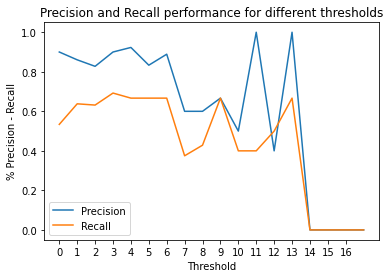

In [ ]:
# 8.1 Proof that the threshold is not useful.

def thresholdsvm(value):
    thresholdsvm = list(range(0,value))
    results = pd.DataFrame(columns=['threshol','accuracy','precision','recall','f1','ROC AUC'])
    for i in thresholdsvm:
        try:
            y_train = (y_train_tm>i).astype(float)
            X_train, X_test, y_train, y_test = train_test_split(X_train_tm, y_train,test_size=0.3, random_state=1, stratify = y_train)
            clf = svm.SVC(kernel = 'rbf', C = 1.0)
            clf.fit(X_train, y_train)
            clf.score(X_test, y_test)
            preds = clf.predict(X_test)
            targs = y_test 
            results.loc[i,"threshol"] = i
            results.loc[i,"accuracy"] = metrics.accuracy_score(targs, preds)
            results.loc[i,"precision"] = metrics.precision_score(targs, preds)
            results.loc[i,"recall"] = metrics.recall_score(targs, preds)
            results.loc[i,"f1"] = metrics.f1_score(targs, preds)
            results.loc[i,"ROC AUC"] = metrics.roc_auc_score(targs, preds)
        except:
            pass
    return results;


results_metrics = thresholdsvm(21)      

results_metrics.columns
plt.plot(results_metrics.threshol,results_metrics.precision, label = "Precision")
plt.plot(results_metrics.threshol,results_metrics.recall, label = "Recall")
plt.xticks(range(min(results_metrics.threshol),max(results_metrics.threshol)))
plt.xlabel('Threshold')
plt.ylabel('% Precision - Recall')
plt.title('Precision and Recall performance for different thresholds')
plt.legend()
plt.show()        

### **8.2: As I said before, the idea of ​​the threshold is really bad. To fix that, one option would be to create ranges of values ​​for sales. In this way, we could "balance" the data slightly and then apply some oversampling technique. Here I show an example and then I calculate the confusion matrix.**

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

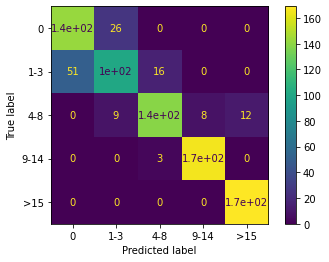

In [ ]:

# 8.2 Create bins (manually unfortunately. I have to change this!)

y_train_tm_range = y_train_tm

range_values = []
for row in y_train_tm_range:
    if row == 0:
        range_values.append('0')
    elif 1<= row <=3: 
        range_values.append('1-3')
    elif 4<= row <=8: 
        range_values.append('4-8')
    elif 9<= row <=14: 
        range_values.append('9-14')
    elif row>=15: 
        range_values.append('>15')
    else: 
        range_values.append('Not_Rated')
        
y_train_tm_range = pd.DataFrame(y_train_tm_range)
y_train_tm_range["range"] = range_values

# 8.3 SMOTE (Oversampling)

from imblearn.over_sampling import SMOTE
oversample = SMOTE()
zX, zy = oversample.fit_resample(X_train_tm, y_train_tm_range.range)

X_train, X_test, y_train, y_test = train_test_split(zX, zy, test_size=0.3, random_state=1, stratify = zy)

#create SVM model and train it
clf = svm.SVC(kernel = 'rbf', C = 1.0)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

preds = clf.predict(X_test)
targs = y_test 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, preds)

plot_confusion_matrix(clf, X_test, y_test)  



In [ ]:
# Calculate the Accuracy, Precision and Recall of the confusion matrix

results_cf_matrix = confusion_matrix(y_test, preds) #Create the confusion matrix

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements



print("accuracy: ",accuracy(results_cf_matrix))

accuracy:  0.8517200474495848


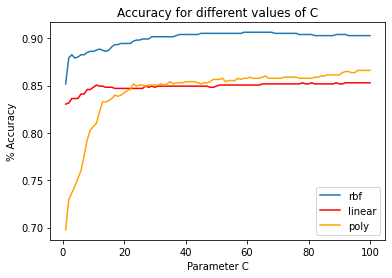

In [ ]:
# 8.4 optimization of the SVM model

def optimization_svm(x,y):
    results_svm_op = []
    for kernel in ('linear', 'poly', 'rbf'):
        for C in range(1,101):
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify = y)
            clf = svm.SVC(kernel = kernel, C = C)
            clf.fit(X_train, y_train)
            clf.score(X_test, y_test)
            preds = clf.predict(X_test) 
            targs = y_test 
            results_cf_matrix = confusion_matrix(y_test, preds)
            results_svm_op.append([kernel,C,accuracy(results_cf_matrix)])
            df_results_svm_op= pd.DataFrame(results_svm_op, columns=['kernel', 'C', 'accuracy'])
    return(df_results_svm_op)



results_opt_svm = optimization_svm(zX, zy)

plt.plot(results_opt_svm[results_opt_svm["kernel"] == "rbf"].C,results_opt_svm[results_opt_svm["kernel"] == "rbf"].accuracy, label = "rbf")
plt.plot(results_opt_svm[results_opt_svm["kernel"] == "rbf"].C,results_opt_svm[results_opt_svm["kernel"] == "linear"].accuracy, color = "red", label = "linear")
plt.plot(results_opt_svm[results_opt_svm["kernel"] == "rbf"].C,results_opt_svm[results_opt_svm["kernel"] == "poly"].accuracy, color = "orange", label = "poly")
plt.xlabel('Parameter C')
plt.ylabel('% Accuracy')
plt.title('Accuracy for different values ​​of C')
plt.legend()
plt.show()        


In [ ]:
results_opt_svm.sort_values("accuracy", ascending = False)

,kernel,C,accuracy
263,rbf,64,0.906287
267,rbf,68,0.906287
258,rbf,59,0.906287
259,rbf,60,0.906287
260,rbf,61,0.906287
...,...,...,...
104,poly,5,0.752076
103,poly,4,0.743772
102,poly,3,0.736655
101,poly,2,0.729537


Accuracy:  0.9062870699881376


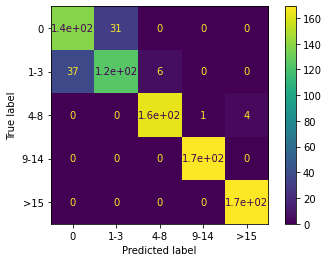

In [ ]:
# 8.5 Final Model

X_train, X_test, y_train, y_test = train_test_split(zX, zy, test_size=0.3, random_state=1, stratify = zy)

#create SVM model and train it
clf = svm.SVC(kernel = 'rbf', C = 64)

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

preds = clf.predict(X_test)
targs = y_test 

results_cf_matrix = confusion_matrix(y_test, preds)
plot_confusion_matrix(clf, X_test, y_test)  

print("Accuracy: ",accuracy(results_cf_matrix))

Finally, the model achieved an accuracy of 90%, going from a regression problem to a classification problem. This is due to the low amount of data to estimate sales for some sensors in particular.